## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names

for columns in list(df.columns):
  print(columns)

_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [5]:
# View the dimensions of dataframe
df.shape

(78313, 22)

In [6]:
# Looking at the dataframe info.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#Assign new column names

# Removing '_' before the column names
df.columns = [re.sub('^_', '', col) for col in df.columns]

# Removing the prefix source from the column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [8]:
#Assign nan in place of blanks in the complaints column

df['complaint_what_happened'] = df['complaint_what_happened'].replace("", np.nan)

In [9]:
#Remove all rows where complaints column is nan

df.dropna(subset=['complaint_what_happened'], inplace=True)

In [10]:
# Checking the shape of the dataframe again
df.shape

(21072, 22)

### We have reduced the number of rows from 78313 to 21072

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.



def clean(text):
    
    
    # convert to lowercase
    text = text.lower()
    
    # Removing square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Removing punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Removing  words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text


In [12]:
#Write your function to Lemmatize the texts

def lemmatize(text):     
    
    # Creating an empty list to store lemmas
    lemmas = []
    
    # Extract lemmas of given text and add to the list 'lemmas'
    doc = nlp(text)
    for word in doc:
        lemmas.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemmas)


In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

# Inserting cleaned complains in the new dataframe.

df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean(x)))

# Inserting a new column for lemmatized compalains in the new dataframe

df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatize(x['complaint_what_happened']), axis=1)

In [14]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact xxxx and be refer to chase bank i then immediately contact chase bank within no more than of get the notification on the screen and i be tell by the chase represent

In [15]:
#Write your function to extract the POS tags 


# Extract singular nouns
def singular_nouns(text):

    
    # Create a textblob object
    blob = TextBlob(text)
    
    # extracting words with tags 'NN'
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

# Apply the function to create a new column containing only singular nouns 

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: singular_nouns(x['lemmatized_complaint']), axis=1)




In [16]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come acro

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




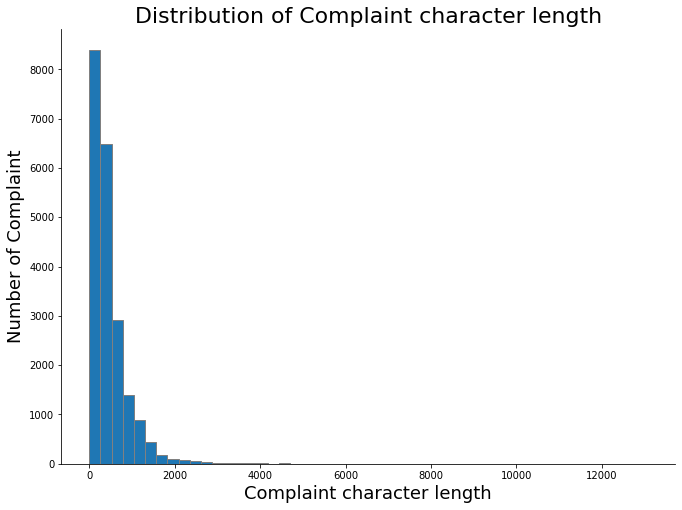

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length

# Making a list to store the length of pre-processed complaint.

length = [len(word) for word in df_clean['complaint_POS_removed']]

# Visualizing the data according to character length of complaints

plt.figure(figsize=(11,8))
plt.hist(length,edgecolor='grey', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=22)
plt.ylabel('Number of Complaint', fontsize=18)
plt.xlabel('Complaint character length', fontsize=18)
sns.despine()
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

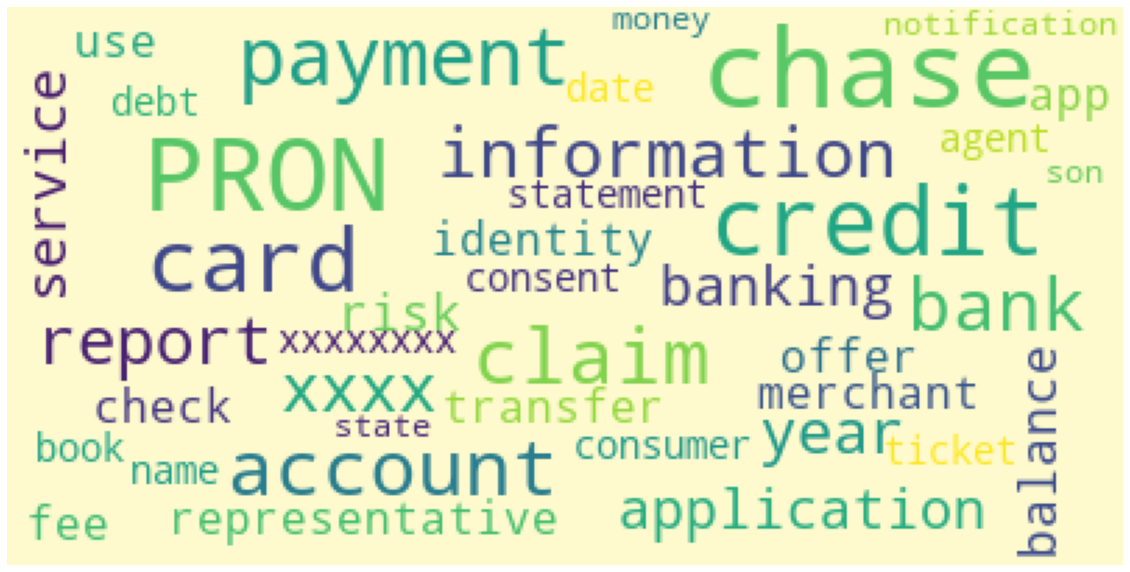

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text


# Plotting the word cloud of the top 40 words by their frequecy.

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [20]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told 

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 


# Writing a function to find the top n words in the corpus 
def top_n_uni(data, n=None):

    vec = CountVectorizer(stop_words='english').fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Getting the top 30 uigram frequency

common_words = top_n_uni(df_clean['complaint_POS_removed'].values.astype('U'), 30)
top_30_uni = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

print(top_30_uni)


        unigram  count
0          pron  73660
1         chase  50015
2       account  47168
3        credit  34149
4          xxxx  34013
5          card  29071
6          bank  28392
7       payment  21159
8          time  16025
9        charge  15539
10          day  12970
11        check  12130
12        money  11961
13     xxxxxxxx  11596
14         loan  10999
15       letter   9669
16  information   9654
17        state   9629
18       report   9570
19          fee   8699
20  transaction   8648
21       number   8620
22        claim   8556
23        month   8460
24         year   8291
25     mortgage   8190
26     customer   8163
27      balance   7768
28        phone   7719
29      service   7665


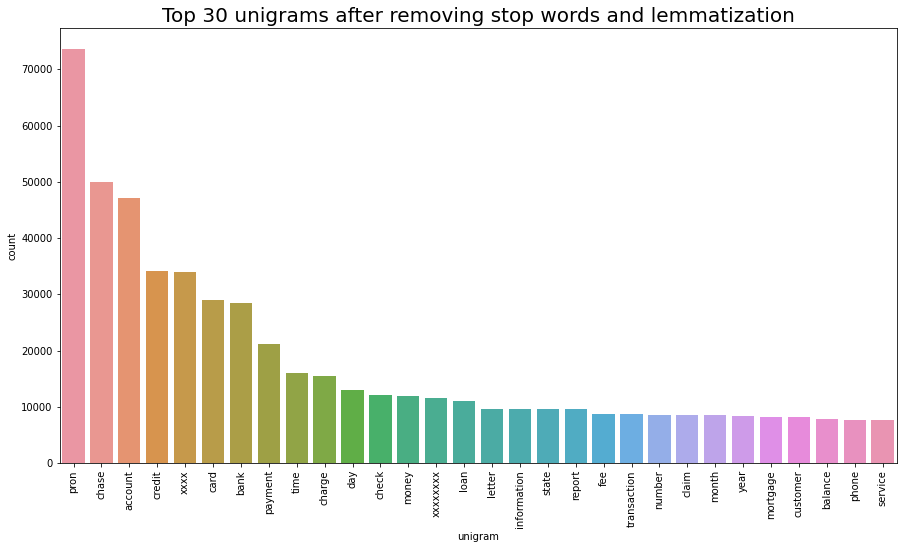

In [22]:
# Plotting the top 30 unigrams.

plt.figure(figsize=(15,8))
sns.barplot(x='unigram', y='count', data= top_30_uni )
plt.xticks(rotation=90)
plt.title("Top 30 unigrams after removing stop words and lemmatization", fontsize=20)
plt.show()


In [23]:
#Print the top 10 words in the unigram frequency

top_30_uni.unigram[:10]


0       pron
1      chase
2    account
3     credit
4       xxxx
5       card
6       bank
7    payment
8       time
9     charge
Name: unigram, dtype: object

In [24]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

# Creating a function to get the top n biagrams

def top_n_bigram(corpus, n=None):
    
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

    # Getting the top 30 bigrams by frequency among all the complaints

common_words = top_n_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
top_30_bi = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

print(top_30_bi)


              bigram  count
0        credit card  12765
1          pron pron   4182
2       pron account   3998
3      credit report   3979
4          xxxx xxxx   3411
5         chase bank   3360
6   customer service   3078
7       chase credit   2889
8       bank account   2690
9      account chase   2628
10      account pron   2578
11     chase account   2280
12        chase pron   2214
13   account account   2071
14     check account   1951
15       pron credit   1946
16      credit score   1623
17      account bank   1612
18        pron chase   1574
19      card account   1536
20        debit card   1431
21         xxxx pron   1382
22    account credit   1354
23       inform pron   1330
24        card chase   1316
25        state pron   1303
26      business day   1264
27     money account   1259
28      phone number   1259
29        pron money   1238


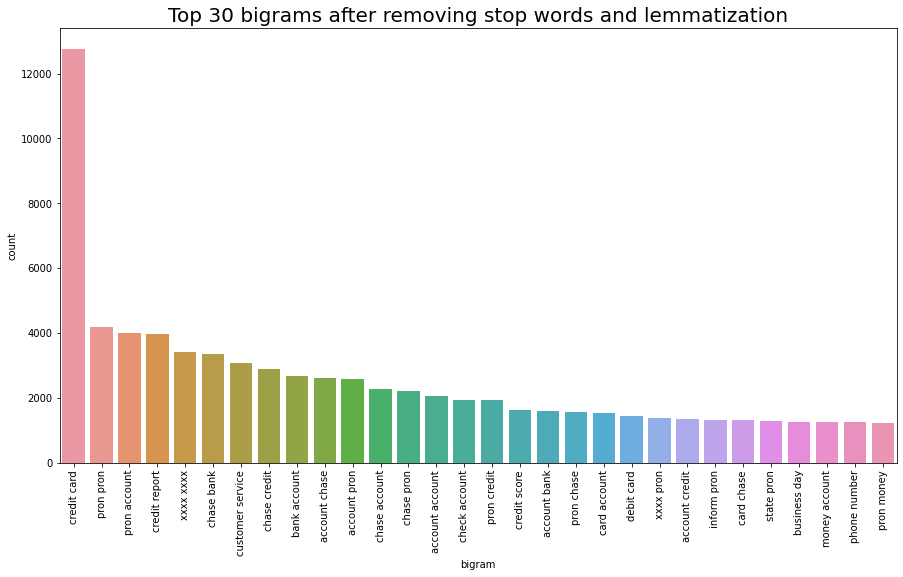

In [25]:
# Plotting the top 30 bigrams.
plt.figure(figsize=(15,8))
sns.barplot(x='bigram', y='count', data=top_30_bi)
plt.xticks(rotation=90)
plt.title("Top 30 bigrams after removing stop words and lemmatization", fontsize=20)
plt.show()

In [26]:
#Print the top 10 words in the bigram frequency
top_30_bi.bigram[:10]

0         credit card
1           pron pron
2        pron account
3       credit report
4           xxxx xxxx
5          chase bank
6    customer service
7        chase credit
8        bank account
9       account chase
Name: bigram, dtype: object

In [27]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

# Creating a function to get the top n trigram 

def top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Getting the top 30 trigram

common_words = top_n_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
top_30_tri = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
print(top_30_tri)



                       trigram  count
0            chase credit card   2005
1          credit card account   1006
2          credit card company    988
3            credit card chase    633
4             pron credit card    605
5        inquiry credit report    488
6           credit card credit    460
7           charge credit card    436
8       chase customer service    403
9      credit reporting agency    381
10            credit card pron    378
11         account credit card    368
12            credit card bank    348
13            bank credit card    346
14              xxxx xxxx xxxx    340
15        credit reporting act    336
16            card credit card    335
17        credit report credit    326
18          credit card charge    294
19              pron pron pron    286
20         credit card payment    285
21            xxxx credit card    281
22           pron account pron    280
23       account credit report    265
24            credit card xxxx    262
25      chas

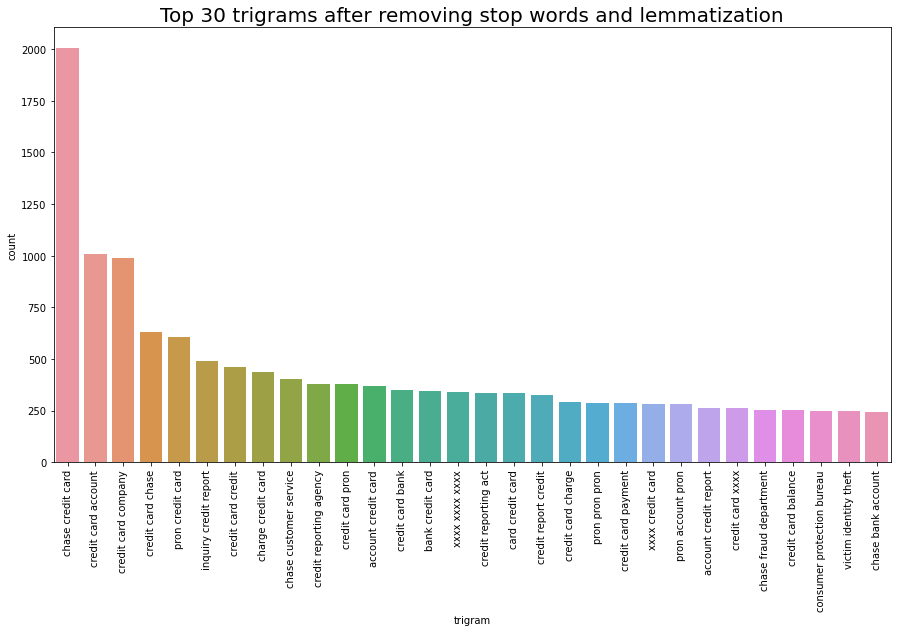

In [28]:
# Plotting the top 30 trigrams.

plt.figure(figsize=(15,8))
sns.barplot(x='trigram', y='count', data=top_30_tri)
plt.xticks(rotation=90)
plt.title("Top 30 trigrams after removing stop words and lemmatization", fontsize=20)
plt.show()

In [29]:
#Print the top 10 words in the trigram frequency

top_30_tri.trigram[:10]

0          chase credit card
1        credit card account
2        credit card company
3          credit card chase
4           pron credit card
5      inquiry credit report
6         credit card credit
7         charge credit card
8     chase customer service
9    credit reporting agency
Name: trigram, dtype: object

In [30]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told 

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
# Replacing the masked info the dataset with ''.

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [32]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the ch

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer 


# Initializing  TfidfVectorizer.

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Creating document term matrix.

dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [35]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [36]:
#Load your nmf_model with the n_components i.e 5
#keep the random_state =40

nmf_model = NMF(n_components=5, random_state=40)

In [37]:
# Fitting the model on document term matrix
nmf_model.fit(dtm)

# View the number of features
len(tfidf.get_feature_names())


7503

In [38]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'The top 15 words for topic # {index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

The top 15 words for topic # 0
['transfer', 'transaction', 'business', 'number', 'day', 'xxxx', 'branch', 'deposit', 'chase', 'fund', 'money', 'pron', 'check', 'bank', 'account']


The top 15 words for topic # 1
['letter', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'pron', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


The top 15 words for topic # 2
['foreclosure', 'house', 'document', 'rate', 'time', 'letter', 'property', 'year', 'modification', 'chase', 'xxxx', 'home', 'pron', 'mortgage', 'loan']


The top 15 words for topic # 3
['refund', 'xxxxxxxx', 'service', 'fraud', 'claim', 'merchant', 'purchase', 'xxxx', 'transaction', 'dispute', 'fee', 'chase', 'pron', 'card', 'charge']


The top 15 words for topic # 4
['chase', 'xxxx', 'account', 'credit', 'time', 'date', 'auto', 'xxxxxxxx', 'pay', 'day', 'fee', 'statement', 'month', 'balance', 'payment']




In [39]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

results = nmf_model.transform(dtm)
results[0].round(2)
results[0].argmax()
results.argmax(axis=1)


array([2, 3, 1, ..., 3, 4, 4])

In [40]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = results.argmax(axis = 1)

In [41]:
# Viewing the dataframe 

df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,3
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was to

In [42]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,i open an account with chase bank on xxxx and use a code for xxxx bonus i call to follow up on xxxxxxxx about the term and be tell everything be on the account and once i make xxxx direct deposit the bonus would be pay out in day as of xxxx i have make the required deposit and be tell -PRON- account never have the coupon code apply and -PRON- be past the day to do so so no bonus would be pay,i account bank code bonus i term everything account deposit bonus day xxxx deposit account coupon code apply -PRON- day bonus,i account bank code bonus i term everything account deposit bonus day deposit account coupon code apply day bonus,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen check number xxxx claim number be xxxx with chase,son check deposit -PRON- chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [43]:
#Create the dictionary of Topic names and Topics

Topic_names = {  
               0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"
 }
 
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [44]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,Others
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,Theft/Dispute Reporting
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proce

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [45]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4 }
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,3
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was to

In [47]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

# creating a new dataframe with the columns  "complaint_what_happened" & "Topic".
training_data = df_clean[["complaint_what_happened","Topic"]]

In [48]:
# Checking the new dataframe 'training_data

training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,3
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me\n\nchase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for xxxx enrollment and failed to credit airline charge as agreed upon,1
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make a claim under their purchase protection benefit on xxxxxxxx i purchased three high school textbooks for my xxxx year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the chase representative assured me th

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [49]:

#Write your code to get the Vector count
count_vector = CountVectorizer()
x_train_count = count_vector.fit_transform(training_data['complaint_what_happened'])


#Write your code here to transform the word vector to tf-idf

tfidf_trans = TfidfTransformer()
x_train_tfidf = tfidf_trans.fit_transform(x_train_count)

In [50]:
# Dividing data into test and train set
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, training_data.Topic, test_size=0.20, random_state=40)

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (16857, 33599)
y_train: (16857,)
x_test: (4215, 33599)
y_test: (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Model Building

###  Selecting Evaluation Metric 

- As the target variable is not normal and there is imbalance of classes, we select **F1 Score** as our evaluation metric for comparing the performance of various models we will build.
- Moreover, we will use a **weighted average** method for evaluating `F1 Score` due to the imbalance of classes

### Model 1 : Logistic Regression

In [51]:

# Creating a simple Logistic Regression model.

model_1 = LogisticRegression()
model_1.fit(x_train, y_train)
y_pred_1 = model_1.predict(x_test)



In [53]:
# Calculating f1 score for the Logistic Regression model.

score_1 = f1_score(y_test, y_pred_1, average="weighted")
print(score_1)

0.9233545561970825


### Model 2 : Decision Tree

In [54]:
# Creating a basic Decision Tree model


model_2 =  DecisionTreeClassifier()
model_2.fit(x_train, y_train)

y_pred_2 = model_2.predict(x_test)

In [55]:
# Calculating f1 score for the Decision Tree model.

score_2 = f1_score(y_test, y_pred_2, average="weighted")
print(score_2)

0.7787712876227433


### Model 3: Random Forest

In [56]:
# Creating a basic Random Forest model

model_3 = RandomForestClassifier()
model_3.fit(x_train, y_train)

y_pred_3 = model_3.predict(x_test)

In [57]:
# calculating f1 score for the Random Forest model.


score_3 = f1_score(y_test, y_pred_3, average="weighted")
print(score_3)

0.8169189227831254


### Looking at all the models we can say that Logistic Regression model works better even without hyperparameter tuning. Therefore, we will use this model for predictions as well.

## Model Inference

In [58]:
# Creating a Function to predict a topic for given text


def predicting_topic(text):
    
    target = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    x_text_count = count_vector.transform(text)
    x_test_tfidf = tfidf_trans.transform(x_text_count)
    predicted = model_1.predict(x_test_tfidf)

    return target[predicted[0]]

In [59]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_new

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and their locations in the city of Dubai


In [60]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predicting_topic([x]))
df_new

,complaints,predicted topic
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Others
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit card or prepaid card
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Credit card or prepaid card
5,I need to know the number of bank branches and their locations in the city of Dubai,Bank Account services


### We can coclude that our model can classify texts very well.